________________________________________________________________________________
# Spam Detection
________________________________________________________________________________

Disclaimer

________________________________________________________________________________
## Import libraries
________________________________________________________________________________


In [1]:
## Tunnel
!npm install -g localtunnel

## !pip install libraries
!pip install -q streamlit

## Data manipulation
import pandas as pd

## Algebra
import numpy as np

## Plot and visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from matplotlib import pyplot
import seaborn as sns
import plotly.graph_objects as go

## Modeling
from sklearn.naive_bayes import MultinomialNB
import lightgbm as lgb
from sklearn.model_selection import train_test_split

## Saving Model
import joblib
from joblib import dump
import pickle

## Text and Deep Learning
import nltk
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import spacy
import string
from nltk.corpus import stopwords
from tensorflow import keras
from gensim.models import Word2Vec, FastText
from gensim.models import KeyedVectors
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import PorterStemmer

## Dimensionality
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

## Utils
import re
import os

## Metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import brier_score_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

## Web-app deploy
import streamlit as st

## Download punkt
nltk.download('punkt')

## Download nltk 
nltk.download('averaged_perceptron_tagger')

## Downloading stopwords
nltk.download('stopwords')

/tools/node/bin/lt -> /tools/node/lib/node_modules/localtunnel/bin/lt.js
+ localtunnel@2.0.2
updated 1 package in 0.641s


   ╭───────────────────────────────────────────────────────────────╮
   │                                                               │
   │      New major version of npm available! 6.14.8 → 8.4.1       │
   │   Changelog: https://github.com/npm/cli/releases/tag/v8.4.1   │
   │               Run npm install -g npm to update!               │
   │                                                               │
   ╰───────────────────────────────────────────────────────────────╯

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

________________________________________________________________________________
## Step-I-EDA

________________________________________________________________________________


In [2]:
## Loading Database
sms = pd.read_csv('/content/drive/MyDrive/spam-detection/spam.csv', encoding = 'latin-1')

## Dropping Unnamed Columns
sms = sms.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'], axis=1)
#sms.head()

In [3]:
## Renaming columns
sms = sms.rename(columns={'v1': 'LABEL', 'v2': 'SMS'})
sms.head()

,LABEL,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
## Descricao dos dados
sms.describe()

,LABEL,SMS
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [5]:
## Dupplicated Messages
duplicated_sms = sms[sms.duplicated()]
print(duplicated_sms[:5])

    LABEL                                                SMS
102   ham  As per your request 'Melle Melle (Oru Minnamin...
153   ham  As per your request 'Melle Melle (Oru Minnamin...
206   ham  As I entered my cabin my PA said, '' Happy B'd...
222   ham                             Sorry, I'll call later
325   ham                   No calls..messages..missed calls


In [6]:
## Verificando o balanceamento dos dados
sms.groupby('LABEL').describe().T

#Observa-se que os dados encontram-se desbalanceados
#com 1500 mensagens como "blocked" e 4500 como "ok"

#Ainda, identificam-se mensagens mais comuns:
#Para Label "blocked": "Mercado BTC ..." 
#Para Label "ok": "131.221.110.19 DNS-SECUNDARIO"

LABEL                          ham                                               spam
SMS count                     4825                                                747
    unique                    4516                                                653
    top     Sorry, I'll call later  Please call our customer service representativ...
    freq                        30                                                  4

- WordCloud

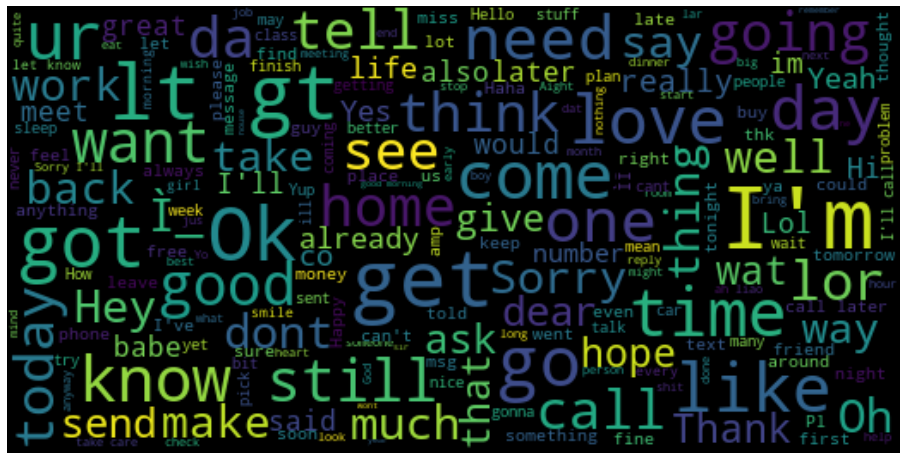

In [7]:
## Separated Datasets accordingly to Labels 
ham_sms = " ".join(list(sms[sms.LABEL == 'ham']['SMS']))
spam_sms = " ".join(list(sms[sms.LABEL == 'spam']['SMS']))

## Defining stopwords in english
stopwords_en = nltk.corpus.stopwords.words('english')

## WordCloud for the Label "ham"
ham_sms_cloud = WordCloud(width = 520, height = 260, stopwords=stopwords_en,
                           max_font_size = 50, background_color ="black", colormap = 'viridis').generate(ham_sms)
plt.figure(figsize=(16,10))
plt.imshow(ham_sms_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.savefig('ham_cloud.png',dpi = 300)
plt.show()

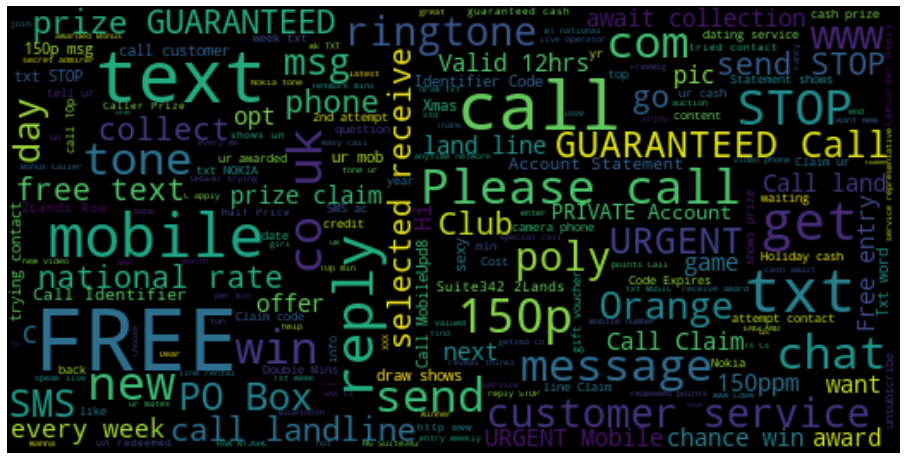

In [8]:
## WordCloud for the Label "spam"
spam_sms_cloud = WordCloud(width = 520, height = 260, stopwords=stopwords_en,
                           max_font_size = 50, background_color ="black", colormap = 'viridis').generate(spam_sms)
plt.figure(figsize=(16,10))
plt.imshow(spam_sms_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.savefig('spam_cloud.png',dpi = 300)
plt.show()

________________________________________________________________________________
## Step-II-Balancing Data

________________________________________________________________________________


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


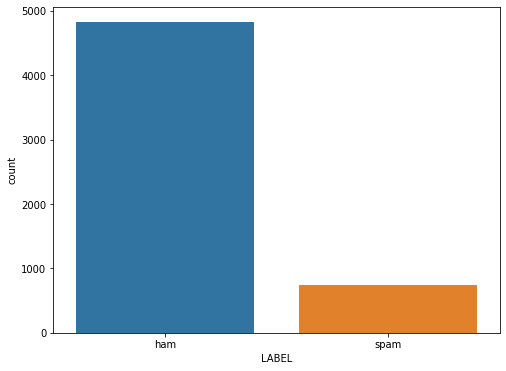

In [9]:
## Plotting the unbalenceddataset
plt.figure(figsize = (8,6))
sns.countplot(sms.LABEL)
plt.savefig('unbalenced-data.png')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


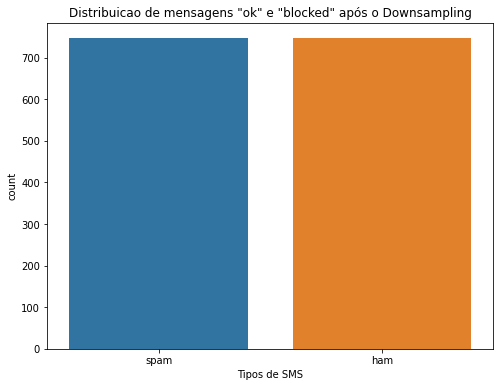

In [10]:
## Redefining datasets
ham_sms_df = sms[sms.LABEL == 'ham']
spam_sms_df = sms[sms.LABEL == 'spam']

## Downsampling
ham_sms_df_downsampled = ham_sms_df.sample(n = len(spam_sms_df),random_state = 44)

## Balanced Dataframe
sms_df = spam_sms_df.append(ham_sms_df_downsampled).reset_index(drop= True)

## Plotting balanced dataframe
plt.figure(figsize = (8,6))
sns.countplot(sms_df.LABEL)
plt.title('Distribuicao de mensagens "ok" e "blocked" após o Downsampling')
plt.xlabel('Tipos de SMS')
plt.savefig('balanced.png')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Tipos de SMS')

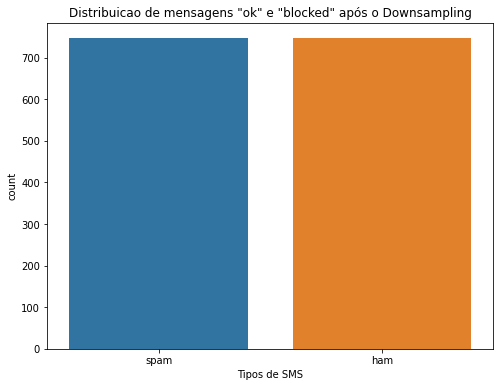

In [11]:
## Criando o DataFrame de análise balanceado
sms_df = spam_sms_df.append(ham_sms_df_downsampled).reset_index(drop= True)

## Plotando o dataset balanceado
plt.figure(figsize=(8,6))
sns.countplot(sms_df.LABEL)
plt.title('Distribuicao de mensagens "ok" e "blocked" após o Downsampling')
plt.xlabel('Tipos de SMS')

In [12]:
## Obtendo o length // comprimento médio dos SMS por Labels
sms_df['text_length'] = sms_df['SMS'].apply(len)

## Calculando a média do comprimento dos labels
labels = sms_df.groupby('LABEL').mean()
labels

#Observa-se a semelhanca na extensao média nas sentencas

,text_length
LABEL,
ham,69.626506
spam,138.866131


________________________________________________________________________________
## Step-III-Preprocessing

________________________________________________________________________________


In [13]:
## Mapping labels and attributing numeric values
## By that, defining 0 for "ham" and 1 for "spam"

'''
Numeric label:
[0]--->['ham']
[1]--->['spam']
'''
sms_df['label_numeric']= sms_df['LABEL'].map({'ham': 0, 'spam': 1})

## Defining X and Y
X = sms_df['SMS']
y = sms_df['label_numeric']

## Data preprocessing and cleaning
def preprocess_sms(x):
    stemmer = PorterStemmer()
    corpus = []
    # Keeping the text and removing the stopwords
    for i in range(0, len(sms_df)):
        words = re.sub('[^a-zA-Z]', ' ', sms_df['SMS'][i])
        words = words.lower()

        # Extracting SMS
        words = words.split()[1:]
    
        words = [stemmer.stem(word) for word in words if word not in set(stopwords.words('english'))]
        words = ' '.join(words)
        corpus.append(words)
    return corpus

corpus_ = preprocess_sms(sms_df['SMS'])

## Bag of words with 1000 most frequent words
cv = CountVectorizer()
X = cv.fit_transform(corpus_).toarray()

## Saving Preprocessing Model
pickle.dump(cv, open('tranform_sms.pkl', 'wb'))

## Split Train, test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.20, random_state=0)

In [14]:
## Data preprocessing e cleaning
def preprocess_sms(x):
    stemmer = PorterStemmer()
    corpus = []
    # Para cada texto, reter apenas letras e remover stopwords
    for i in range(0, len(sms_df)):
        words = re.sub('[^a-zA-Z]', ' ', sms_df['SMS'][i])
        words = words.lower()

        # Remover o texto do SMS
        words = words.split()[1:]
    
        words = [stemmer.stem(word) for word in words if word not in set(stopwords.words('english'))]
        words = ' '.join(words)
        corpus.append(words)
    return corpus

corpus_ = preprocess_sms(sms_df['SMS'])

## Bag of words do modelo e extraindo as 1000 palavras mias frequentes   

cv = CountVectorizer()
X = cv.fit_transform(corpus_).toarray()

## Salvando o modelo de Preprocessing
pickle.dump(cv, open('tranform_sms.pkl', 'wb'))

In [15]:
## Split Train, test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.20, random_state=0)

__________________________________________________________________________
## Step-IV-Modeling

__________________________________________________________________________

_________________________________________________________________________
###Naive Bayes MultinomialNB
_________________________________________________________________________

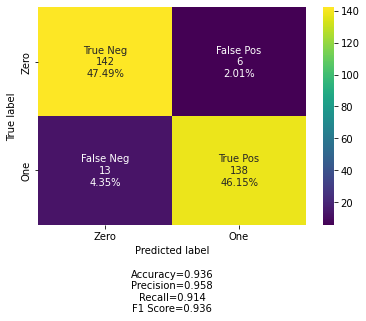

In [16]:
## Model Naibe Bayes Multinomial
clf_naive = MultinomialNB().fit(X_train, y_train)

## Predicting
y_pred = clf_naive.predict(X_test)

## Confusion Matrix
cf_matrix = confusion_matrix(y_test, y_pred)

## Function to calculate metrics based on Confusion Matrix
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Purples',
                          title=None):

    # Calculating the squares of the Confusiin Matrix
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # Summary statistics
    if sum_stats:
        #Accuracy
        accuracy  = np.trace(cf) / float(np.sum(cf))
        #If binary, do:
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # Figure params
    if figsize==None:
        #Default Figure size
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #if xyticks false, do not show categories
        categories=False


    # Heatmap 
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
        plt.savefig('Naive-Bayes-Metrics.png')
    else:
        plt.xlabel(stats_text)
        plt.savefig('Naive-Bayes-Metrics.png')
    
    if title:
        plt.title(title)
        plt.savefig('Naive-Bayes-Metrics.png')

## Plotting Confusion Matrix
labels = ["True Neg", "False Pos", "False Neg", "True Pos"]
categories = ["Zero", "One"]
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories,
                      cmap='viridis')

In [17]:
# Save the model
filename = 'clf_naive.pkl'
pickle.dump(clf_naive, open(filename, 'wb'))

_________________________________________________________________________
###LightGBM
_________________________________________________________________________

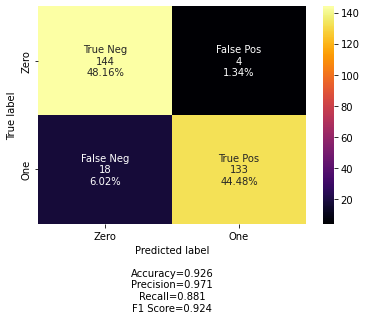

In [18]:
## Criando o modelo de classificacao com LightGBM
clf_light = lgb.LGBMClassifier().fit(X_train, y_train)

## Predicting
y_pred_light = clf_light.predict(X_test)

## Criando a Confusion Matrix
cf_matrix_light = confusion_matrix(y_test, y_pred_light)

## Plotando a Confusion Matrix com métricas principais
labels = ["True Neg", "False Pos", "False Neg", "True Pos"]
categories = ["Zero", "One"]
make_confusion_matrix(cf_matrix_light, 
                      group_names=labels,
                      categories=categories,
                      cmap='inferno')

__________________________________________________________________________
## Parte-V-Web-App Deploy

__________________________________________________________________________

In [20]:
## Streamlit in a LocalTunnel
!streamlit run app_spam.py & npx localtunnel --port 8501

2022-02-04 23:08:29.400 INFO    numexpr.utils: NumExpr defaulting to 2 threads.

  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.2:8501
  External URL: http://35.185.58.161:8501

npx: installed 22 in 3.116s
your url is: https://cuddly-bulldog-78.loca.lt
  Stopping...
^C
